# Data Analysis on Fortune 500 Companies Over 50 years
Author: Yuchen Zhang (yz674)

This is a sample shows the usage of Jupyter Notebook in a simple data analysis task. The goal is to find out how the profits of the largest companies in the US changed historically. This notebook shows the step-by-step process of data cleaning, data analysis and data plotting by making use of Jupyter's support on the integration of Markdown documents, code input & output and all kinds of visualizations.


Import modules we need before getting started. The imported libraries and some of the functions are placed into `lib.py` so that they can be shared across different files.

In [0]:
# Import functions
from pyspark.sql.functions import col, current_timestamp

# Define variables used in code below
file_path = "/databricks-datasets/structured-streaming/events"
username = spark.sql("SELECT regexp_replace(current_user(), '[^a-zA-Z0-9]', '_')").first()[0]
table_name = f"{username}_etl_quickstart"
checkpoint_path = f"/tmp/{username}/_checkpoint/etl_quickstart"

# Clear out data from previous demo execution
spark.sql(f"DROP TABLE IF EXISTS {table_name}")
dbutils.fs.rm(checkpoint_path, True)

# Configure Auto Loader to ingest JSON data to a Delta table
try:
  (spark.readStream
    .format("cloudFiles")
    .option("cloudFiles.format", "json")
    .option("cloudFiles.schemaLocation", checkpoint_path)
    .load(file_path)
    .select("*", col("_metadata.file_path").alias("source_file"), current_timestamp().alias("processing_time"))
    .writeStream
    .option("checkpointLocation", checkpoint_path)
    .trigger(availableNow=True)
    .toTable(table_name))
except Exception as e:
    print(f'Error: {e}')

In [0]:
import pandas as pd # noqa: F401
import matplotlib.pyplot as plt # noqa: F401
def plot(x, y, ax, title, y_label, debug=False):
    if debug is False:
        ax.set_title(title)
        ax.set_ylabel(y_label)
        ax.plot(x, y)
        ax.margins(x=0, y=0)

    return 'plot completed!'

def plot_with_std(x, y, stds, ax, title, y_label, debug=False):
    if debug is False:
        ax.fill_between(x, y - stds, y + stds, alpha=0.2)
        plot(x, y, ax, title, y_label)

    return 'plot_with_std completed!'

Load the raw csv file in a separate cell, in case we want to load the file again for debugging.

In [0]:
url = "https://raw.githubusercontent.com/nogibjj/IDS706_Fall2023_Project_1_CI_Python_DS/main/data/fortune500.csv"
df = pd.read_csv(url)

Data cleaning. Ensure that the csv file loaded only includes valid data.

year         int64
rank         int64
company     object
revenue    float64
profit     float64
dtype: object

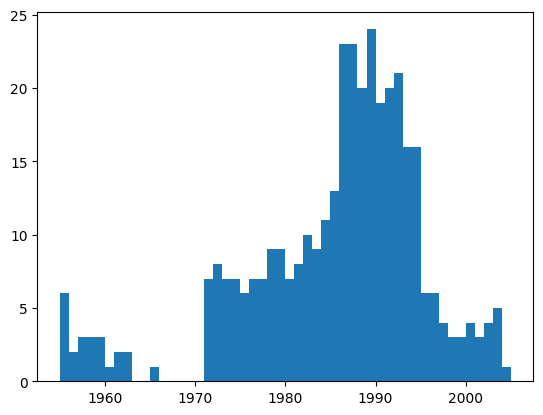

In [0]:
# Rename the columns for better readability
df.columns = ['year', 'rank', 'company', 'revenue', 'profit']

# Look into the profit column. We only want numbers - use regex as a filter.
non_numberic_profits = df.profit.str.contains('[^0-9.-]')

# Check the invalid value set
set(df.profit[non_numberic_profits])

# Show the distribution of invalid value
bin_sizes, _, _ = plt.hist(df.year[non_numberic_profits], bins=range(1955, 2006))

# Remove the invalid values, then convert all the profit values into numeric for plotting
df = df.loc[~non_numberic_profits]
df.profit = df.profit.apply(pd.to_numeric)

# Check if the length and value types of the dataframe match our expectations
len(df)
df.dtypes

Data analysis. Group the data by year, calculate the mean values, and plot the revenue and profit change over the 50 years.

'plot completed!'

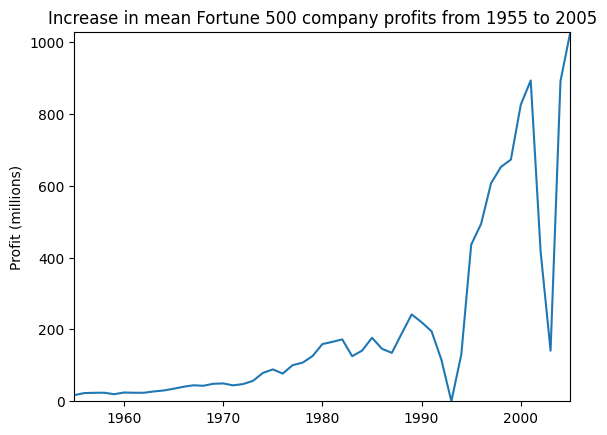

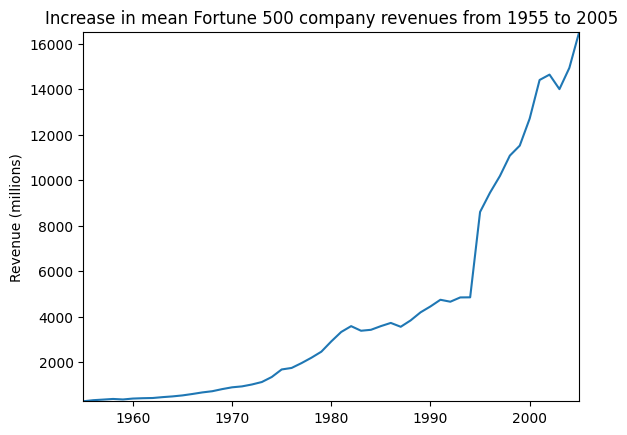

In [0]:
group_by_year = df.loc[:, ['year', 'revenue', 'profit']].groupby('year')
avgs = group_by_year.mean()
x = avgs.index
y1 = avgs.profit
fig, ax = plt.subplots()
plot(x, y1, ax, 'Increase in mean Fortune 500 company profits from 1955 to 2005', 'Profit (millions)')

y2 = avgs.revenue
fig, ax = plt.subplots()
plot(x, y2, ax, 'Increase in mean Fortune 500 company revenues from 1955 to 2005', 'Revenue (millions)')

Data plotting. Superimpose the plots above with +/- their standard deviations.

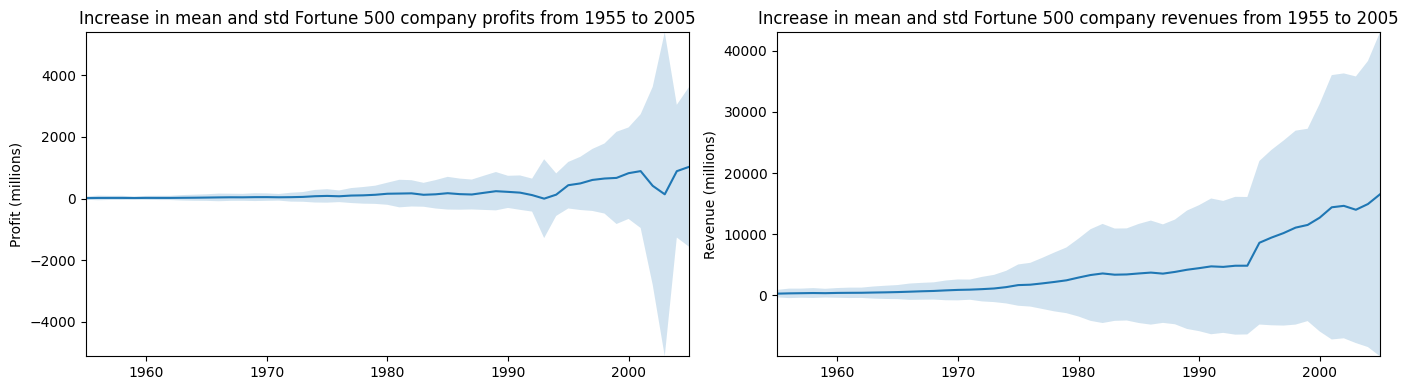

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
title = 'Increase in mean and std Fortune 500 company %s from 1955 to 2005'
stds1 = group_by_year.std().profit.values
stds2 = group_by_year.std().revenue.values
plot_with_std(x, y1.values, stds1, ax1, title % 'profits', 'Profit (millions)')
plot_with_std(x, y2.values, stds2, ax2, title % 'revenues', 'Revenue (millions)')
fig.set_size_inches(14, 4)
fig.tight_layout()

In [0]:
# Convert Pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(df)

# Specify the Delta table destination
delta_table_path = "dbfs:/tmp/myDeltaTable"

# Write the Spark DataFrame (converted from Pandas) to the Delta table
spark_df.write.format("delta").mode("overwrite").save(delta_table_path)